# Build train and test matrices

In [1]:
import pandas as pd
import numpy as np
import feather

df = (feather.read_dataframe('/home/SHARED/SOLAR/data/oahu_min.feather')
             .set_index('Datetime'))

In [2]:
# https://stackoverflow.com/questions/15722324/sliding-window-in-numpy
def window_stack_forward(a, stepsize=1, width=3):
    return np.hstack( a[i:1+i-width or None:stepsize] for i in range(0, width) )

In [3]:
# I feel this function can also be done for pd.DataFrame
def window_stack(a, width=3):
    n = a.shape[0]
    return np.hstack(list(a[(width-1-i):(n-i)] for i in range(0, width)))

In [4]:
# In pandas 0.24, use df.to_numpy() instead of df.values. Also care with non-numeric columns
width = 61
a = window_stack(df.values, width=width)

In [5]:
times   = [ ('t' if not idx else 't-{:d}'.format(idx)) for idx in range(width) ]
columns = pd.MultiIndex.from_product((times, df.columns), names=('time', 'location'))

In [6]:
# Convert back to DataFrame, just for convenience of having indexes
df_roll = pd.DataFrame(a, index=df.index[width-1:], columns=columns)

In [7]:
# Split target (time t) and variables (times t-1 to t-width+1)
y = df_roll['t']
X = df_roll.drop(columns='t', level='time')

In [8]:
# Split train-test, approximately 12 and 4 months respectively
X_train, X_test = X[:'2011-07-31'], X['2011-08-01':]
y_train, y_test = y[:'2011-07-31'], y['2011-08-01':]

In [9]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(449885, 1140)
(82892, 1140)
(449885, 19)
(82892, 19)


# Train Elastic Net model

In [10]:
from contextlib import contextmanager
from timeit import default_timer

@contextmanager
def timer(tag=None):
    start = default_timer()
    try:
        yield
    finally:
        end = default_timer()
        print(('[{}] '.format(tag) if tag else '') +
               'Elapsed time (s): {:.6f}'.format(end - start))

In [11]:
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import TimeSeriesSplit

enet = ElasticNetCV(n_jobs=10, cv=TimeSeriesSplit(n_splits=5), l1_ratio=0.5)
with timer():
    enet.fit(X_train, y_train['GH_AP1'])

Elapsed time (s): 663.945411


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [12]:
print('R^2 (train): {}'.format(enet.score(X_train, y_train['GH_AP1'])))
print('R^2 (test): {}'.format(enet.score(X_test, y_test['GH_AP1'])))
print('alpha: {}'.format(enet.alpha_))
print('l1_ratio: {}'.format(enet.l1_ratio_))

R^2 (train): 0.8996642313321442
R^2 (test): 0.8810550943484787
alpha: 229.09871455104192
l1_ratio: 0.5


In [13]:
%matplotlib inline
res = pd.DataFrame({'Actual': y_test['GH_AP1'], 'Pred': enet.predict(X_test)})

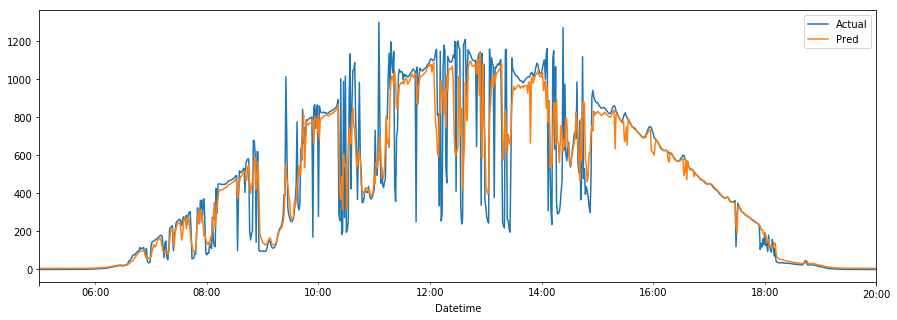

In [14]:
res['20110801'].plot(figsize=(15, 5));

In [15]:
from sklearn.metrics import mean_absolute_error

In [16]:
res['abs_error'] = res['Actual'].sub(res['Pred']).abs()

In [17]:
res['abs_error'].mean()

56.42577223776865

In [ ]:
from sklearn.linear_model import MultiTaskElasticNetCV
from sklearn.multioutput import MultiOutputRegressor

enet = MultiOutputRegressor(ElasticNetCV(cv=TimeSeriesSplit(n_splits=5), l1_ratio=0.5), n_jobs=10)
with timer():
    enet.fit(X_train, y_train)

In [ ]:
y_test_pred = pd.DataFrame(enet.predict(X_test), index=y_test.index, columns=y_test.columns)

In [ ]:
res = pd.concat((y_test, y_test_pred), axis=1, keys=['Actual', 'Pred'])

In [ ]:
res.stack(level='location').groupby('location').apply(lambda s: mean_absolute_error(s['Actual'], s['Pred'])).sort_values()

Conclusiones:
* Ajustar los 19 modelos ENet tarda poco más de 1h con `n_jobs=10`
* Parece que hay bastantes diferencias entre estaciones

**TODO**:
* Hacer un mapa de las estaciones coloreado por MAE, a ver si tienen alguna distribución espacial
* Probar otros modelos
* Normalizar las series temporales entre [0, 1]?
* Probar con distintos valores de `width`, como si fuera un hiperparámetro
* Ver sparsity
* Ajustar otros modelos (RandomForest, GradientBoosting, Neural Networks)

In [ ]:
df.describe()